## Imports and global parameters

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import keras
import optuna
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import pandas as pd
import cv2 
import os
import sys
import random
import logging
from sklearn.model_selection import train_test_split, KFold
from keras import layers
from optuna.visualization import plot_slice

2024-08-21 17:35:53.106546: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-21 17:35:53.159612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 17:35:53.159645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 17:35:53.161044: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 17:35:53.170357: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-21 17:35:53.170810: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
IMG_PATH = 'img/'
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IM_SHAPE = (500,500, 3)
MAX_EPOCHS = 40
MODEL_SELECTION_STEPS = 2

BACKBONE_MODEL = 'efficientnet'

## Image preprocessing

Given any occupancy gridmap, the image is padded and rescaled in order to be a squared picture of size `IM_SHAPE`

In [3]:
def square_img(imPath: tf.Tensor):
    path = bytes.decode(imPath.numpy())
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape
    h_diff = 0 if h >= w else abs(h - w) // 2
    w_diff = 0 if w >= h else abs(h - w) // 2
    squared_img = cv2.copyMakeBorder(img, h_diff, h_diff, w_diff, w_diff, cv2.BORDER_CONSTANT, value=205)
    pad = 25
    squared_img = squared_img[pad:-pad, pad:-pad]   # partially remove the gray padding
    square_img = cv2.resize(squared_img, IM_SHAPE[:-1], interpolation=cv2.INTER_LINEAR)
    return cv2.cvtColor(square_img, cv2.COLOR_GRAY2RGB) / 255.

# Data preprocessing

### Read csv files and create datasets

In [4]:
df = pd.read_csv('data.csv')
df['id'] = df['id'].apply(lambda id: os.path.join(IMG_PATH, id))
df.head()

,id,translErr,rotErr
0,img/32-G5.png,0.549900,0.049978
1,img/32-G7.png,0.655930,0.048543
2,img/32-G9.png,0.461634,0.035468
3,img/32-D8.png,0.518458,0.041766
4,img/W31-2.png,0.222666,0.017267


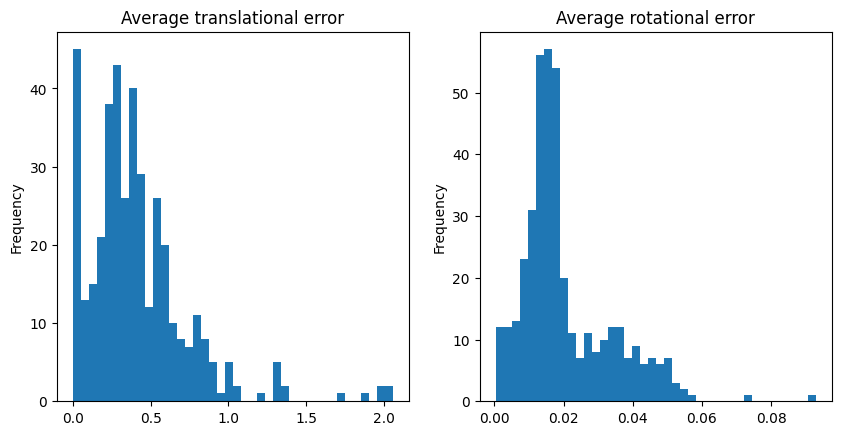

In [5]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
df['translErr'].plot.hist(bins=40, title='Average translational error', ax=ax[0])
df['rotErr'].plot.hist(bins=40, title='Average rotational error', ax=ax[1])
plt.show()

#### Data rescaling

In [6]:
# TODO: ragiona bene su scaling dei dati
rescaler_rot = sk.preprocessing.MinMaxScaler()
rescaler_transl = sk.preprocessing.MinMaxScaler()
df['rotErr'] = rescaler_rot.fit_transform(df['rotErr'].values.reshape(-1,1)).squeeze()
df['translErr'] = rescaler_transl.fit_transform(df['translErr'].values.reshape(-1,1)).squeeze()
df.head()

,id,translErr,rotErr
0,img/32-G5.png,0.266868,0.536063
1,img/32-G7.png,0.318330,0.520562
2,img/32-G9.png,0.224028,0.379322
3,img/32-D8.png,0.251607,0.447355
4,img/W31-2.png,0.108043,0.182710


##### Data partitioning and dataset creation

In [7]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [8]:
@tf.function(reduce_retracing=True)
def load_image(id):
    image = tf.py_function(func=square_img, inp=[id], Tout=tf.float32)
    image.set_shape(IM_SHAPE)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    return image


def data_augmentation(img):
    rotation = random.randint(0, 3)
    img = tf.image.rot90(img, k=rotation)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_flip_left_right(img)
    return img


def load_dataset(df: pd.DataFrame, augment=False) -> tf.data.Dataset:
    X = tf.data.Dataset.from_tensor_slices(df["id"].values)
    Y = tf.data.Dataset.from_tensor_slices(df[["translErr", "rotErr"]].values)

    X = X.map(load_image, num_parallel_calls=AUTO)
    
    if augment:
        X = X.map(lambda img: data_augmentation(img), num_parallel_calls=AUTO)

    dataset = tf.data.Dataset.zip(X, Y)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(
        batch_size=BATCH_SIZE,
        num_parallel_calls=AUTO,
        deterministic=False,
        drop_remainder=False,
    )
    dataset = dataset.prefetch(AUTO)
    return dataset


train_data = load_dataset(train_df, augment=True)
val_data = load_dataset(val_df)
test_data = load_dataset(test_df)

In [9]:
next(train_data.take(1).as_numpy_iterator())

(array([[[[0.8039216, 0.8039216, 0.8039216],
          [0.8039216, 0.8039216, 0.8039216],
          [0.8039216, 0.8039216, 0.8039216],
          ...,
          [0.8039216, 0.8039216, 0.8039216],
          [0.8039216, 0.8039216, 0.8039216],
          [0.8039216, 0.8039216, 0.8039216]],
 
         [[0.8039216, 0.8039216, 0.8039216],
          [0.8039216, 0.8039216, 0.8039216],
          [0.8039216, 0.8039216, 0.8039216],
          ...,
          [0.8039216, 0.8039216, 0.8039216],
          [0.8039216, 0.8039216, 0.8039216],
          [0.8039216, 0.8039216, 0.8039216]],
 
         [[0.8039216, 0.8039216, 0.8039216],
          [0.8039216, 0.8039216, 0.8039216],
          [0.8039216, 0.8039216, 0.8039216],
          ...,
          [0.8039216, 0.8039216, 0.8039216],
          [0.8039216, 0.8039216, 0.8039216],
          [0.8039216, 0.8039216, 0.8039216]],
 
         ...,
 
         [[0.8039216, 0.8039216, 0.8039216],
          [0.8039216, 0.8039216, 0.8039216],
          [0.8039216, 0.803921

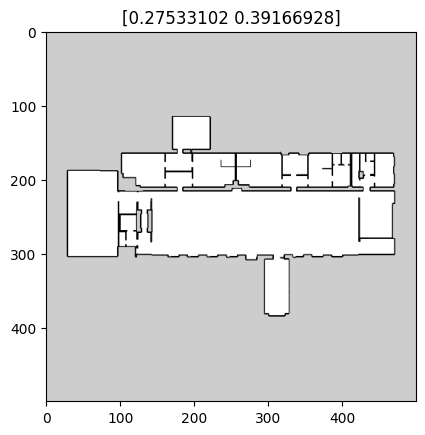

In [10]:
for r in train_data.take(1).as_numpy_iterator():
    r, l = r[0], r[1]
    plt.imshow(r[0], cmap='gray')
    plt.title(l[0])
    plt.show()
    break

In [11]:
def plot_history(hst: keras.callbacks.History):
    metrics = ["loss"]
    _, ax = plt.subplots(1, len(metrics), figsize=(15, 5))
    for _, metric in enumerate(metrics):
        ax.plot(hst.history[metric])
        ax.plot(hst.history["val_" + metric])
        ax.set(title="model " + metric, ylabel=metric, xlabel="epoch")
        ax.legend([metric, "val_" + metric], loc="upper left")
    plt.show()

## Define the CNN structure

In [12]:
def _build_efficientNet(input):
    w, h = (300, 300)
    resize = layers.Resizing(h, w)
    effNet = keras.applications.EfficientNetV2B3(include_top=False, input_shape=(w, h, 3), pooling="avg")
    effNet.trainable = False
    x = resize(input)
    return effNet(x)


def _build_mobileNet(input):
    w, h = (224, 224)
    resize = layers.Resizing(h, w)
    mobNet = keras.applications.MobileNetV3Large(include_top=False, input_shape=(w, h, 3), pooling="avg")
    mobNet.trainable = False
    x = resize(input)
    return mobNet(x)

def _build_ViT(input):
    VIT = hub.KerasLayer("https://www.kaggle.com/models/spsayakpaul/vision-transformer/TensorFlow2/vit-b16-fe/1")
    VIT.trainable = False
    x = layers.Resizing(224,224)(input)
    return VIT(x)


def build_model(config: dict) -> keras.Model:  # EfficientNetV2B3
    backbone_builder = {
        "efficientnet": _build_efficientNet,
        "mobilenet": _build_mobileNet,
        "vit": _build_ViT
    }

    backbone = backbone_builder[BACKBONE_MODEL]
    input_layer = layers.Input(shape=IM_SHAPE)
    x = backbone(input_layer)

    for i in range(config["nLayers"]):
        x = layers.Dense(units=config[f"layer{i}_units"], name=f"dense_{i}")(x)
        if config["batchNorm"]:
            x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)

        if config["dropout"]:
            x = layers.Dropout(0.3)(x)

    out = layers.Dense(2, "sigmoid", name="out_layer")(x)

    model = keras.Model(input_layer, out, name=f"{BACKBONE_MODEL}_model")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config["lr"]), loss="mse"
    )
    return model

In [13]:
baselineHyperparameters = {
    "lr": 1e-4,
    "nLayers": 3,
    "batchNorm": False,
    "dropout": True,
    "layer0_units": 1024,
    "layer1_units": 512,
    "layer2_units": 128,
}
m = build_model(baselineHyperparameters)
es = keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
hst = m.fit(
    train_data, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_data=val_data, callbacks=[es]
)

Epoch 1/40
9/9 [==============================] - 50s 4s/step - loss: 0.0647 - val_loss: 0.0170
Epoch 2/40
3/9 [=========>....................] - ETA: 16s - loss: 0.0321

KeyboardInterrupt: 

In [27]:
plot_history(hst)

NameError: name 'hst' is not defined

### Hyperparameter tuning

In [28]:
def objective(trial: optuna.Trial) -> float:
    best_val_loss = np.inf
    patience = 0
    config = {
        "lr": trial.suggest_float("lr", 1e-6, 1e-3, log=True),
        "nLayers": trial.suggest_int("nLayers", 1, 7),
        "batchNorm": trial.suggest_categorical("batchNorm", [True, False]),
        "dropout": trial.suggest_categorical("dropout", [True, False]),
    }
    for i in range(config["nLayers"]):
        config[f"layer{i}_units"] = trial.suggest_categorical(
            f"layer{i}_units", [64, 128, 256, 512, 1024]
        )

    model = build_model(config)

    for train_step in range(MAX_EPOCHS):
        history = model.fit(train_data, batch_size=BATCH_SIZE, validation_data=val_data)
        val_loss = history.history["val_loss"][0]
        # Implement earlystopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1

        if patience > 5:
            break

        trial.report(val_loss, train_step)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_val_loss

In [31]:
def kFoldCV(hyperPar: dict, training_set: pd.DataFrame, k: int) -> float:
    df = training_set.reset_index(drop=True)
    kf = KFold(n_splits=k, shuffle=True)
    scores = []
    for trainIdx, valIdx in kf.split(df):
        train_data = load_dataset(df.iloc[trainIdx], augment=True)
        val_data = load_dataset(df.iloc[valIdx])

        model = build_model(hyperPar)
        
        es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
        model.fit(train_data, 
                  batch_size=BATCH_SIZE,
                  validation_data=val_data,
                  epochs=MAX_EPOCHS,
                  callbacks=[es]
                  )
        
        result = model.evaluate(val_data, batch_size=BATCH_SIZE)
        scores.append(result)
    return np.avg(scores)   # TODO: magari ritorna tutto l'array così calcoli varianza sui fold?

#### Optimize EfficientNetV2

In [32]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='efficientNet_study'
)

study.enqueue_trial(baselineHyperparameters)    # Test on baseline parameters first and optimize from there
study.optimize(objective, n_trials=MODEL_SELECTION_STEPS, gc_after_trial=True)

[I 2024-08-21 14:55:00,622] A new study created in memory with name: efficientNet_study


A new study created in memory with name: efficientNet_study
A new study created in memory with name: efficientNet_study


[W 2024-08-21 14:55:35,518] Trial 0 failed with parameters: {'lr': 0.0001, 'nLayers': 3, 'batchNorm': False, 'dropout': True, 'layer0_units': 1024, 'layer1_units': 512, 'layer2_units': 128} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/matteo/Desktop/Statisticalmethods/StatisticalMethodsProject/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_391838/446237556.py", line 18, in objective
    history = model.fit(train_data, batch_size=BATCH_SIZE, validation_data=val_data)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/matteo/Desktop/Statisticalmethods/StatisticalMethodsProject/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/matteo/D

Trial 0 failed with parameters: {'lr': 0.0001, 'nLayers': 3, 'batchNorm': False, 'dropout': True, 'layer0_units': 1024, 'layer1_units': 512, 'layer2_units': 128} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/matteo/Desktop/Statisticalmethods/StatisticalMethodsProject/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_391838/446237556.py", line 18, in objective
    history = model.fit(train_data, batch_size=BATCH_SIZE, validation_data=val_data)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/matteo/Desktop/Statisticalmethods/StatisticalMethodsProject/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/matteo/Desktop/Statisticalmethods/St

[W 2024-08-21 14:55:35,523] Trial 0 failed with value None.


Trial 0 failed with value None.
Trial 0 failed with value None.


KeyboardInterrupt: 

In [14]:
# import pickle
# #pickle.dump(study,open(b'study.pkl', 'wb'))
# f = open('study.pkl', 'rb')
# study = pickle.load(f)

In [15]:
plot_slice(study)

In [23]:
study.best_params

In [ ]:
CV_loss_effNet = kFoldCV(study.best_params, train_df, 5)

model = build_model(study.best_params)
test_loss_effNet = model.evaluate(test_data)

In [ ]:
print(f'CV loss over training set: {CV_loss_effNet}\nLoss over the test set: {test_loss_effNet}')

#### Optimize MobileNetV3_large

In [ ]:
BACKBONE_MODEL = 'mobilenet'

In [ ]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='mobileNet_study'
)

study.enqueue_trial(baselineHyperparameters)    # Test on baseline parameters first and optimize from there
study.optimize(objective, n_trials=MODEL_SELECTION_STEPS, gc_after_trial=True)

In [ ]:
plot_slice(study)

In [ ]:
study.best_params

In [ ]:
CV_loss_mobNet = kFoldCV(study.best_params, train_df, 5)

model = build_model(study.best_params)
test_loss_mobNet = model.evaluate(test_data)

In [ ]:
print(f'CV loss over training set: {CV_loss_mobNet}\nLoss over the test set: {test_loss_mobNet}')

## Experimenting with Vision Transformers

In [14]:
VIT = hub.KerasLayer("https://www.kaggle.com/models/spsayakpaul/vision-transformer/TensorFlow2/vit-b16-fe/1")
VIT.trainable = False

In [24]:
input_layer = keras.layers.Input(shape=IM_SHAPE)
x = keras.layers.Resizing(224,224)(input_layer)
x = VIT(x)
x = keras.layers.Dense(256, activation='relu')(x)
out_layer = keras.layers.Dense(2, activation='sigmoid')(x)

model = keras.Model(input_layer, out_layer)

model.compile('adam', 'mse')

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 resizing_2 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 768)               85798656  
                                                                 
 dense (Dense)               (None, 1024)              787456    
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 86849026 (331.30 MB)
Trainable params: 1050370 

In [22]:
hst = model.fit(
    train_data,
    batch_size = BATCH_SIZE,
    epochs=3,
    validation_data=val_data
)

Epoch 1/3


2024-08-21 17:44:30.127534: I external/local_xla/xla/service/service.cc:168] XLA service 0x70d56d3d6e90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-08-21 17:44:30.127572: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-08-21 17:44:30.397173: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1724255075.780064  495688 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-08-21 17:44:35.791333: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


9/9 [==============================] - 103s 10s/step - loss: 0.0873 - val_loss: 0.0412
Epoch 2/3
1/9 [==>...........................] - ETA: 1:24 - loss: 0.0762

KeyboardInterrupt: 